### CFD To DSMC

Importing libraries

In [19]:
import numpy as np

import torch
import torch.nn as nn
from torch import Tensor
import torch.optim as optim

import time
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.model_selection import train_test_split

Read the CFD data

In [20]:
CF=pd.read_csv("INPUT (CF).csv")
CF=np.array(CF)[:-3,:]  # 255 values
print(CF.shape[0])

252


Read the DSMC data

In [21]:
DSMC=pd.read_csv("Output (DSMC).csv")
DSMC=np.array(DSMC)     # 252 values
print(DSMC.shape[0]) 

252


In [22]:
X_train, X_test, Y_train,Y_test=train_test_split(CF,DSMC,test_size=0.2,random_state=42)

Feature scaling

In [23]:
#from sklearn.preprocessing import StandardScaler
#sc=StandardScaler()

#X_train=sc.fit_transform(X_train)
#print(type(Y_train))

#X_test=sc.transform(X_test)
#print(X_test)

Convert numpy to Torch

In [24]:
# PyTorch takes Tensor data so convert the data to Tensor
X_train=torch.from_numpy(X_train).float()
X_test=torch.from_numpy(X_test).float()

Y_train=torch.from_numpy(Y_train).float()
Y_test=torch.from_numpy(Y_test).float()

#print(X_train.shape)

In [25]:
print(type(Y_train))

<class 'torch.Tensor'>


### Neural Network 

In [26]:
#print(X_train,Y_train)

class CFD_DSMC(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.activation=nn.Tanh()
        self.loss_function=nn.MSELoss(reduction="mean")
        self.linears=nn.ModuleList([nn.Linear(layers[i],layers[i+1])for i in range(len(layers)-1)])
        self.iteration=0
    
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data,gain=5/3)
            nn.init.zeros_(self.linears[i].bias.data)
        
    def forward(self,X):
        if torch.is_tensor(X)!=True:
            X=torch.from_numpy(X)
        a=X.float()
        for i in range(len(layers)-2):
            z=self.linears[i](a)
            a=self.activation(z)
        a=self.linears[-1](a)
        return a
    def loss(self,X,Y):
        a=self.forward(X)
        loss_val=self.loss_function(a,Y)
        return loss_val
    
    def closure(self):
        optimizer.zero_grad()

        Total_loss=self.loss(X_train,Y_train)
        Total_loss.backward()
        
        self.iteration+=1
        if self.iteration%100==0:
            print(Total_loss)
        return Total_loss
    def test(self,Test_data):
        XY=self.forward(Test_data)
        return XY

## Main Function

In [27]:
layers=np.array([2,8,8,8,8,2])
yo=CFD_DSMC(layers)
params=list(yo.parameters())
optimizer=torch.optim.LBFGS(yo.parameters(),lr=0.1,max_iter=50000,tolerance_grad=1e-15,max_eval=None,tolerance_change=1e-9,history_size=1000,line_search_fn="strong_wolfe")


start_time=time.time()
optimizer.step(yo.closure)
Total_time=time.time()-start_time
print(Total_time)

tensor(0.0044, grad_fn=<MseLossBackward0>)
tensor(0.0041, grad_fn=<MseLossBackward0>)
tensor(0.0039, grad_fn=<MseLossBackward0>)
tensor(0.0037, grad_fn=<MseLossBackward0>)
tensor(0.0035, grad_fn=<MseLossBackward0>)
tensor(0.0035, grad_fn=<MseLossBackward0>)
tensor(0.0034, grad_fn=<MseLossBackward0>)
tensor(0.0032, grad_fn=<MseLossBackward0>)
tensor(0.0029, grad_fn=<MseLossBackward0>)
tensor(0.0011, grad_fn=<MseLossBackward0>)
tensor(0.0007, grad_fn=<MseLossBackward0>)
tensor(0.0006, grad_fn=<MseLossBackward0>)
8.104247808456421


### Predicting Test Results

In [28]:
pred_val=yo.test(X_test)


#X_test.shape
Y_test=(Y_test).detach().numpy()

In [29]:
print(pred_val.shape)
pred_val=(pred_val).detach().numpy()
X_pred_val=pred_val[:,[0]]
print(type(X_pred_val))
Y_pred_val=pred_val[:,[1]]
print(type(Y_pred_val))

torch.Size([51, 2])
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Plot

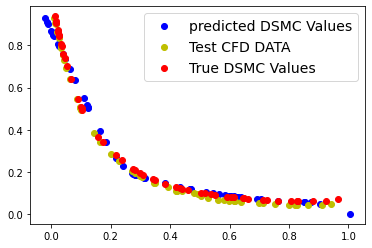

In [30]:
plt.scatter(X_pred_val,Y_pred_val,color="b",label="predicted DSMC Values")
plt.scatter(X_test[:,[0]],X_test[:,[1]],color="y",label="Test CFD DATA")
plt.scatter(Y_test[:,[0]],Y_test[:,[1]],color="r",label="True DSMC Values")

plt.legend(fontsize="14")
plt.show()